# Grouping the HC3N components

We know that at least one of the components in HC3N corresponds to the larger cloud.
We will test the weighted clustering made by Spandan in his Barnard 5 paper

There is an error in the QA of HC3N fit, the npeaks map does not have the same beam (or spatial info) as HC3N, maybe got confuse with the N2Hp map

After looking at the results, we really need the information about the central velocities of the protostars.

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import os

%matplotlib widget

In [2]:
#files
HC3N1gfile = '../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_filtered_QA.fits'
HC3N2gfile = '../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x2_filtered_QA.fits'
HC3N3gfile = '../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x3_filtered_QA.fits'
npeaksfile = '../bayes_frame/nested-sampling/HC3N/npeaks_cut5_noislands_QA.fits'
HC3Ncloudgroupfile = 'HC3N_cloud_params2.fits'


In [3]:
params1g, header1g = fits.getdata(HC3N1gfile, header=True)
params2g, header2g = fits.getdata(HC3N2gfile, header=True)
params3g, header3g = fits.getdata(HC3N3gfile, header=True)
npeaks, npeakshead = fits.getdata(npeaksfile, header=True)
npeaks[np.where(np.isnan(npeaks))] = 0
npeaks = npeaks.astype(int)

mask_npeaksavailable = np.where(npeaks!=0, 1, 0)

averagevel = np.nanmean(params1g[1])
averagetemp = np.nanmean(params1g[0])
weight_def = 0.6 # more weight to V than T
xarray = np.linspace(0, header1g['NAXIS1']-1, header1g['NAXIS1']).astype(int)
yarray = np.linspace(0, header1g['NAXIS2']-1, header1g['NAXIS2']).astype(int)
XX, YY = np.meshgrid(xarray, yarray)

xmax = header1g['NAXIS1']-1
ymax = header1g['NAXIS2']-1

x0 = 348
y0 = 369
print(averagetemp, averagevel)

0.6601216693036815 7.784800863141327


In [4]:
# mask1g = np.where(npeaks==1, 1, 0)
# mask2g = np.where(npeaks==2, 1, 0)
# mask3g = np.where(npeaks==3, 1, 0)

paramscloud = params1g.copy()
evaluated = np.zeros(np.shape(npeaks)).astype(int)
evaluated[np.where(npeaks==1)] = 1
# evaluated[np.where(npeaks==0)] = 1 # that way we do not evaluate the ones that do not have components
evaluated_old = evaluated.copy()

In [5]:
def weighted_distance(velmap, velbase, vel0, Tmap, Tbase, T0, weight):
    deltav = (velmap - velbase) / vel0
    deltaT = (Tmap - Tbase) / T0
    dp = np.sqrt((weight * deltav)**2 + ((1-weight) * deltaT)**2)
    return dp

def distance_pix(x, y, x0, y0):
    return np.sqrt((x-x0)**2 + (y-y0)**2)

def distance_pix_jump(x, y, x0, y0):
    return distance_pix(x, y, x0, y0).astype(int)
    #return np.amax([np.abs(x-x0), np.abs(y-y0)], axis=0)
    # return (np.abs(x-x0) + np.abs(y-y0))

def distance_2G(pixx, pixy, weight, velbase, Tbase):
    vel1 = params2g[1, pixy, pixx]
    T1 = params2g[0, pixy, pixx]
    vel2 = params2g[4, pixy, pixx]
    T2 = params2g[3, pixy, pixx]
    d1 = weighted_distance(vel1, velbase, averagevel, T1, Tbase, averagetemp, weight)
    d2 = weighted_distance(vel2, velbase, averagevel, T2, Tbase, averagetemp, weight)
    return d1, d2


def distance_3G(pixx, pixy, weight, velbase, Tbase):
    vel1 = params3g[1, pixy, pixx]
    T1 = params3g[0, pixy, pixx]
    vel2 = params3g[4, pixy, pixx]
    T2 = params3g[3, pixy, pixx]
    vel3 = params3g[7, pixy, pixx]
    T3 = params3g[6, pixy, pixx]
    
    d1 = weighted_distance(vel1, velbase, averagevel, T1, Tbase, averagetemp, weight)
    d2 = weighted_distance(vel2, velbase, averagevel, T2, Tbase, averagetemp, weight)
    d3 = weighted_distance(vel3, velbase, averagevel, T3, Tbase, averagetemp, weight)
    return d1, d2, d3

def available_neighbors(xx, yy, radius):
    # we need to get all bordering pixels
    
    #considering border cases
    
    if xx==0: neighbors_x = [xx, xx+radius]
    elif xx==xmax: neighbors_x = [xx-radius, xx]
    else: neighbors_x = [xx-radius, xx, xx+radius]
    
    if yy==0: neighbors_y = [yy, yy+radius]
    elif yy==ymax: neighbors_y = [yy-radius, yy]
    else: neighbors_y = [yy-radius, yy, yy+radius]
    
    # we get all possible combinations of x, y
    combos = np.array(np.meshgrid(neighbors_x, neighbors_y)).T.reshape(-1,2)
    return combos #will include the one in the middle

def get_average_values_from_neighbors(xx, yy, paramsmap, radius):
    # border cases
    combos = available_neighbors(xx, yy, radius)
    vel = []
    Tb = []
    for combo in combos:
        vel.append(paramsmap[1, combo[1], combo[0]])
        Tb.append(paramsmap[0, combo[1], combo[0]])
    
    #normal case
    velbase = np.nanmean(vel)
    Tbase = np.nanmean(Tb)
    # if np.all(np.isnan([velbase, Tbase])): print(xx, yy)
    return velbase, Tbase

def evaluate_distance_neighbors(pixx, pixy, weight, paramsmap):
    radiusinit = 1
    velbase = np.nan
    Tbase = np.nan
    while np.isnan(velbase) and np.isnan(Tbase):
        velbase, Tbase = get_average_values_from_neighbors(pixx, pixy, paramsmap, radiusinit)
        radiusinit += 1
    if radiusinit >2: print(pixx, pixy, radiusinit)
    npeaks_pix = npeaks[pixy, pixx] 
    if npeaks_pix == 2:
        d1, d2 = distance_2G(pixx, pixy, weight, velbase, Tbase)
        if d1 < d2:
            return 0
        # else: return 3
        elif d2 < d1:
            return 1
        else: 
            if np.isnan(d1) and ~np.isnan(d2): return 0
            elif np.isnan(d2) and ~np.isnan(d1): return 1
            else: 
                # print('both distances NAN')
                return np.nan
    elif npeaks_pix == 3:
        d1, d2, d3 = distance_3G(pixx, pixy, weight, velbase, Tbase)
        # print(d1, d2, d3)
        # return np.nanargmin(distancearray)
        if np.all(~np.isnan([d1, d2, d3])):
            if d1 < d2 and d1 < d3: return 0
            elif d2 < d1 and d2 < d3: return 1
            elif d3 < d1 and d3 < d2:  return 2
        elif np.any(~np.isnan([d1, d2, d3])): 
            if np.isnan(d1) and ~np.isnan(d2) and ~np.isnan(d3):
                if d2 < d3: return 1
                else: return 2
            elif np.isnan(d2) and ~np.isnan(d1) and ~np.isnan(d3):
                if d1 < d3: return 0
                else: return 2
            elif np.isnan(d3) and ~np.isnan(d1) and ~np.isnan(d2):
                if d1 < d2: return 0
                else: return 1
            else: # 2 nans
                if np.isnan(d1) and np.isnan(d2) and ~np.isnan(d3): return 2
                elif np.isnan(d2) and ~np.isnan(d1) and np.isnan(d3): return 0
                else: return 1
        else:
            # print('all distances NAN')
            return np.nan
    else:
        print('This should not happen')
        return np.nan
    
        

In [6]:

distancematrix = distance_pix_jump(XX, YY, x0, y0) * mask_npeaksavailable
maxdistance = np.nanmax(distancematrix)
# x 217 y 256 gives problems

In [7]:
for i in range(0, maxdistance+1): # evaluate radially
    indexes_eval = np.where(distancematrix == i)
    if np.all(evaluated[indexes_eval]): continue #if all evaluated or if no components in all that radius 
    for y, x in zip(indexes_eval[0], indexes_eval[1]):
        npeaks_pix = npeaks[y, x]
        
        if npeaks_pix == 0 or evaluated[y, x]: 
            continue
        else:
            index_best = evaluate_distance_neighbors(x, y, weight_def, paramscloud)
            # if np.isnan(index_best): continue
            if npeaks_pix == 2:
                paramscloud[0, y, x] = params2g[index_best*3, y, x]
                paramscloud[1, y, x] = params2g[index_best*3+1, y, x]
                paramscloud[2, y, x] = params2g[index_best*3+2, y, x]
                paramscloud[3, y, x] = params2g[index_best*3+6, y, x]
                paramscloud[4, y, x] = params2g[index_best*3+7, y, x]
                paramscloud[5, y, x] = params2g[index_best*3+8, y, x]
            elif npeaks_pix == 3:
                paramscloud[0, y, x] = params3g[index_best*3, y, x]
                paramscloud[1, y, x] = params3g[index_best*3+1, y, x]
                paramscloud[2, y, x] = params3g[index_best*3+2, y, x]
                paramscloud[3, y, x] = params3g[index_best*3+9, y, x]
                paramscloud[4, y, x] = params3g[index_best*3+10, y, x]
                paramscloud[5, y, x] = params3g[index_best*3+11, y, x]
            evaluated[y, x] = 1
    
            # 
        

/var/folders/nt/p37g01ts6h32hk58dz0fw6cc0000gn/T/ipykernel_25391/4141264148.py:65: RuntimeWarning: Mean of empty slice
  velbase = np.nanmean(vel)
/var/folders/nt/p37g01ts6h32hk58dz0fw6cc0000gn/T/ipykernel_25391/4141264148.py:66: RuntimeWarning: Mean of empty slice
  Tbase = np.nanmean(Tb)


376 306 3
377 307 3
378 307 3
379 308 3
380 308 3
381 309 3
382 309 3
376 305 3
380 307 3
381 308 3
382 308 3
383 309 3
384 309 3
384 310 3
385 310 3
387 311 3
386 310 3
388 311 3
389 312 3
390 312 3
391 313 3
389 311 3
391 312 3
385 299 3
270 310 3
256 246 3
240 251 3
243 247 3
268 227 3
223 256 3
226 251 3
225 252 3
226 252 3
224 253 3
225 253 3
223 254 3
222 255 4
223 255 3
221 256 3
222 256 3
226 250 3
225 251 4
224 252 4
223 253 3
222 254 4
221 255 4
220 256 3
231 243 3
230 244 3
228 246 3
227 247 3
226 248 4
225 249 4
226 249 3
224 250 5
225 250 4
223 251 5
224 251 4
222 252 4
223 252 4
222 253 4
221 254 5
220 255 4
219 256 3
231 242 3
232 242 3
228 245 3
227 246 3
226 247 3
225 248 5
224 249 4
223 250 5
220 253 3
221 253 5
219 254 4
220 254 5
218 255 4
219 255 4
218 256 3
231 241 3
227 244 4
226 245 4
227 245 3
225 246 4
226 246 4
224 247 6
225 247 5
223 248 3
219 253 3
218 254 4
217 255 4
216 256 3
217 256 3
231 239 3
230 240 3
225 245 3
224 246 4
216 255 3
214 255 3
233 235 3


In [8]:
# do a two pass, where there is nan, save the index and then go again.
x0 = 214
y0 = 259

In [9]:
for i in range(0, maxdistance+1): # evaluate radially
    if np.all(evaluated[indexes_eval]): continue #if all evaluated or if no components in all that radius 
    for y, x in zip(indexes_eval[0], indexes_eval[1]):
        npeaks_pix = npeaks[y, x]
        if npeaks_pix == 0 or evaluated[y, x]: 
            continue
        else:
            index_best = evaluate_distance_neighbors(x, y, weight_def, paramscloud)
            # if np.isnan(index_best): continue
            if npeaks_pix == 2:
                paramscloud[0, y, x] = params2g[index_best*3, y, x]
                paramscloud[1, y, x] = params2g[index_best*3+1, y, x]
                paramscloud[2, y, x] = params2g[index_best*3+2, y, x]
                paramscloud[3, y, x] = params2g[index_best*3+6, y, x]
                paramscloud[4, y, x] = params2g[index_best*3+7, y, x]
                paramscloud[5, y, x] = params2g[index_best*3+8, y, x]
            elif npeaks_pix == 3:
                paramscloud[0, y, x] = params3g[index_best*3, y, x]
                paramscloud[1, y, x] = params3g[index_best*3+1, y, x]
                paramscloud[2, y, x] = params3g[index_best*3+2, y, x]
                paramscloud[3, y, x] = params3g[index_best*3+9, y, x]
                paramscloud[4, y, x] = params3g[index_best*3+10, y, x]
                paramscloud[5, y, x] = params3g[index_best*3+11, y, x]
            evaluated[y, x] = 1
    
            # 
        

In [10]:
fits.writeto(HC3Ncloudgroupfile, paramscloud, header1g)

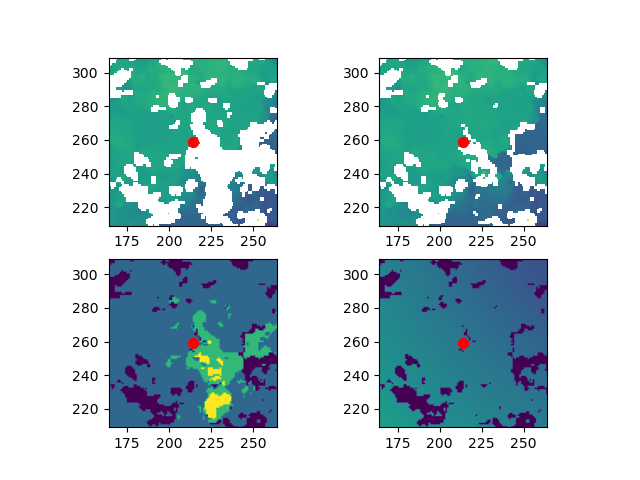

In [11]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.imshow(params1g[1])
ax.set_xlim([x0-50, x0+50])
ax.set_ylim([y0-50, y0+50])
ax.scatter(389, 312, s=50)
ax.scatter(x0, y0, s=50, c='r')
ax2 = fig.add_subplot(222)
ax2.imshow(paramscloud[1])
ax2.set_xlim([x0-50, x0+50])
ax2.set_ylim([y0-50, y0+50])
ax2.scatter(389, 312, s=50)
ax2.scatter(x0, y0, s=50, c='r')
ax3 = fig.add_subplot(223)
ax3.imshow(npeaks)
ax3.set_xlim([x0-50, x0+50])
ax3.set_ylim([y0-50, y0+50])
ax3.scatter(389, 312, s=50)
ax3.scatter(x0, y0, s=50, c='r')
ax4 = fig.add_subplot(224)
ax4.imshow(distancematrix)
ax4.set_xlim([x0-50, x0+50])
ax4.set_ylim([y0-50, y0+50])
ax4.scatter(389, 312, s=50)
ax4.scatter(x0, y0, s=50, c='r')

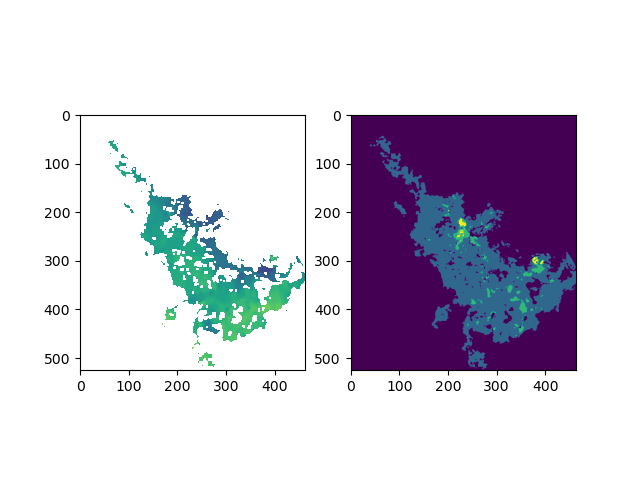

In [11]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(paramscloud[1])
ax2 = fig.add_subplot(122)
ax2.imshow(npeaks)